In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import lightgbm as lgb

df_train = pd.read_csv(('train.csv'))
df_cleaned = pd.read_csv(('df_cleaned.csv'))
# df_test = pd.read_csv('test.csv')
# census = pd.read_csv('census_starter.csv')
# df_sub = pd.read_csv('sample_submission.csv')

In [14]:
cfips_list = df_cleaned.cfips
df_train = df_train[df_train.cfips.isin(cfips_list)]

3086

In [26]:
df = df_train[["cfips", 'first_day_of_month', "microbusiness_density"]]
mask = ((df.microbusiness_density == 0))
df = df.pivot(index='cfips', columns='first_day_of_month', values='microbusiness_density')
df = df.fillna(0)

from sklearn.metrics.pairwise import euclidean_distances
X = df.values
dist = euclidean_distances(X, X)
dist = pd.DataFrame(dist)
dist.index = df.index
dist.columns = dist.index
print(f"Euclidean distances dataframe shape is: {dist.shape}")
dist.head()

Euclidean distances dataframe shape is: (3086, 3086)


cfips,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
cfips,,,,,,,,,,,,,,,,,,,,,
1001,0.000000,29.556795,12.895536,11.874929,9.303092,14.101265,11.065914,2.829182,11.202628,12.504850,...,10.283439,17.809755,2.868046,505.161486,26.203104,2.095152,144.824318,5.660521,1.889969,9.392556
1003,29.556795,0.000000,42.437527,41.393925,38.844253,43.625468,40.379436,32.140328,40.736643,42.032006,...,39.799866,11.863868,27.985019,479.478507,4.196430,29.915355,115.351493,24.934053,31.191761,38.933490
1005,12.895536,42.437527,0.000000,1.215073,3.602387,1.396112,3.678453,10.351931,1.762304,0.665639,...,2.896020,30.665538,14.728440,516.635929,39.064970,12.720783,157.682454,17.941489,11.315041,3.523592
1007,11.874929,41.393925,1.215073,0.000000,2.627938,2.266151,3.664661,9.275294,0.809200,0.850113,...,2.313452,29.609640,13.648139,515.931982,38.045908,11.655409,156.616432,16.856641,10.322504,2.552048
1009,9.303092,38.844253,3.602387,2.627938,0.000000,4.840657,3.203045,6.788592,1.956603,3.226506,...,1.409196,27.079578,11.202883,513.427685,35.472854,9.180298,154.100153,14.426233,7.731779,0.276581


In [27]:
dist.loc[1001,:].sort_values()

cfips
1001       0.000000
42073      0.473444
48245      0.515782
13137      0.554876
13095      0.577685
            ...    
16021    344.838225
46127    393.308149
8105     402.904330
56033    505.161486
32510    777.110402
Name: 1001, Length: 3086, dtype: float64

Text(0, 0.5, 'Microbusiness density')

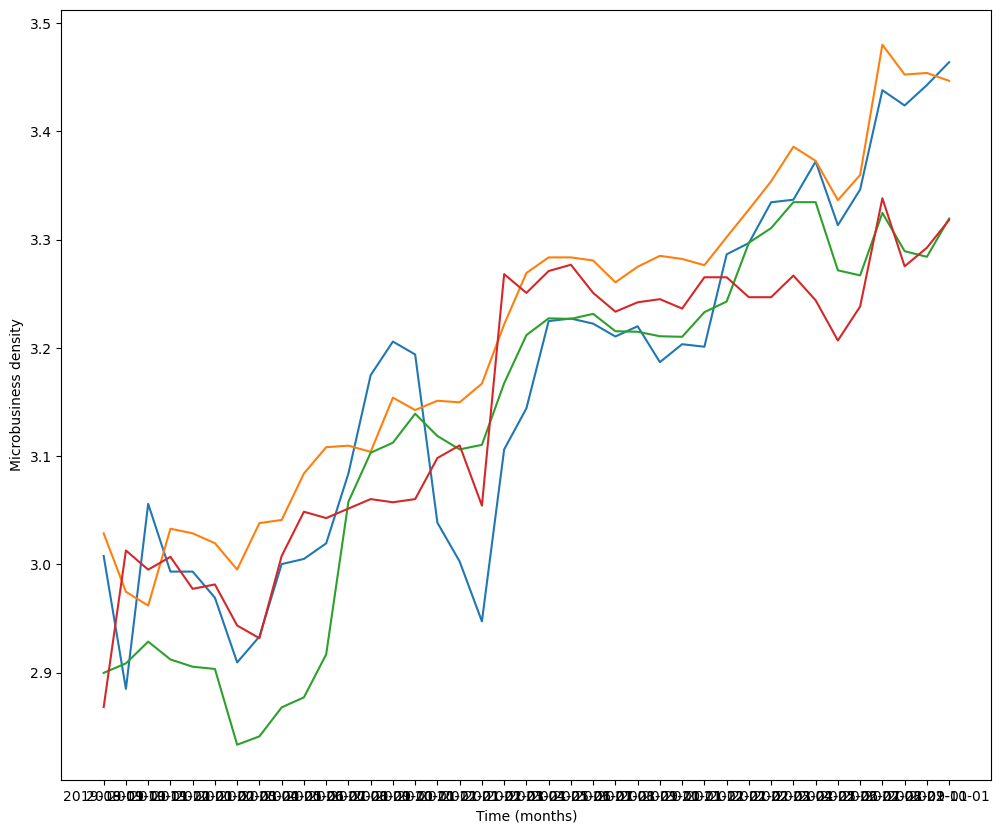

In [28]:
plt.figure(figsize=(12, 10))
plt.plot(df.loc[1001, :])
plt.plot(df.loc[42073, :])
plt.plot(df.loc[48245, :])
plt.plot(df.loc[13137, :])
plt.xlabel("Time (months)")
plt.ylabel("Microbusiness density")

In [24]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import random

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import OPTICS, Birch
from sklearn.neighbors import NearestNeighbors


nn = NearestNeighbors(
                n_neighbors=4, 
                p=2, 
                # metric=metric, 
                # metric_params=metric_params
            )
nn.fit(df)
_, neighbors = nn.kneighbors(df, return_distance=True)
df_nn = pd.DataFrame(neighbors,index=df.index)
df_nn = df_nn.apply(lambda col: df.index[col])
df_nn = df_nn.iloc[:, 1:]
group = df_train.groupby(df_train.cfips)

# nn.fit(df_log_diff)
# _, neighbors = nn.kneighbors(df_log_diff, return_distance=True)
# df_nn_ld = pd.DataFrame(neighbors,index=df.index)
# df_nn_ld = df_nn_ld.apply(lambda col: df.index[col])
# df_nn_ld = df_nn_ld.iloc[:, 1:]
# group = df_train.groupby(df_train.cfips)

feats = []
def generate_feature(df_nn, df, feature):
    cfips = df.cfips.unique()
    df_grouped = df.groupby('cfips')
    for cfips_val in cfips:
        nn_list = df_nn.loc[cfips_val].values.tolist()
        feats = pd.DataFrame(np.asarray([df_grouped.get_group(i)[feature].values for i in nn_list]).T)
    return feats

feature = generate_feature(df_nn, df_train, 'microbusiness_density')  
# feature_ld = generate_feature(df_nn_ld, df_train, 'microbusiness_density')

In [25]:
feature

,0,1,2
0,1.544148,1.518858,1.645351
1,1.575892,1.503568,1.604038
2,1.546415,1.534149,1.591464
3,1.573625,1.508665,1.598649
4,1.555485,1.483180,1.587872
5,1.573217,1.503225,1.587559
6,1.536999,1.543853,1.556891
7,1.541526,1.554009,1.571323
8,1.577744,1.528617,1.605600
9,1.575481,1.584480,1.580343


In [120]:
cfips_to_county = df_train[['cfips', 'county']].drop_duplicates().set_index('cfips')['county'].to_dict()
# cfips_to_county[24005]

df_nn_county1 = df_nn.replace(cfips_to_county)
df_nn_county1[df_nn_county1.index == 24005]
df_nn_county2 = df_nn_ld.replace(cfips_to_county)
df_nn_county2[df_nn_county2.index == 24005]

,1,2,3
cfips,,,
24005,Pottawattamie County,Hudson County,Monmouth County


In [114]:
df_nn[df_nn.index == 24005]

,1,2,3
cfips,,,
24005,29077,39061,18097


In [121]:
df_nn_ld[df_nn_ld.index == 24005]

,1,2,3
cfips,,,
24005,19155,34017,34025


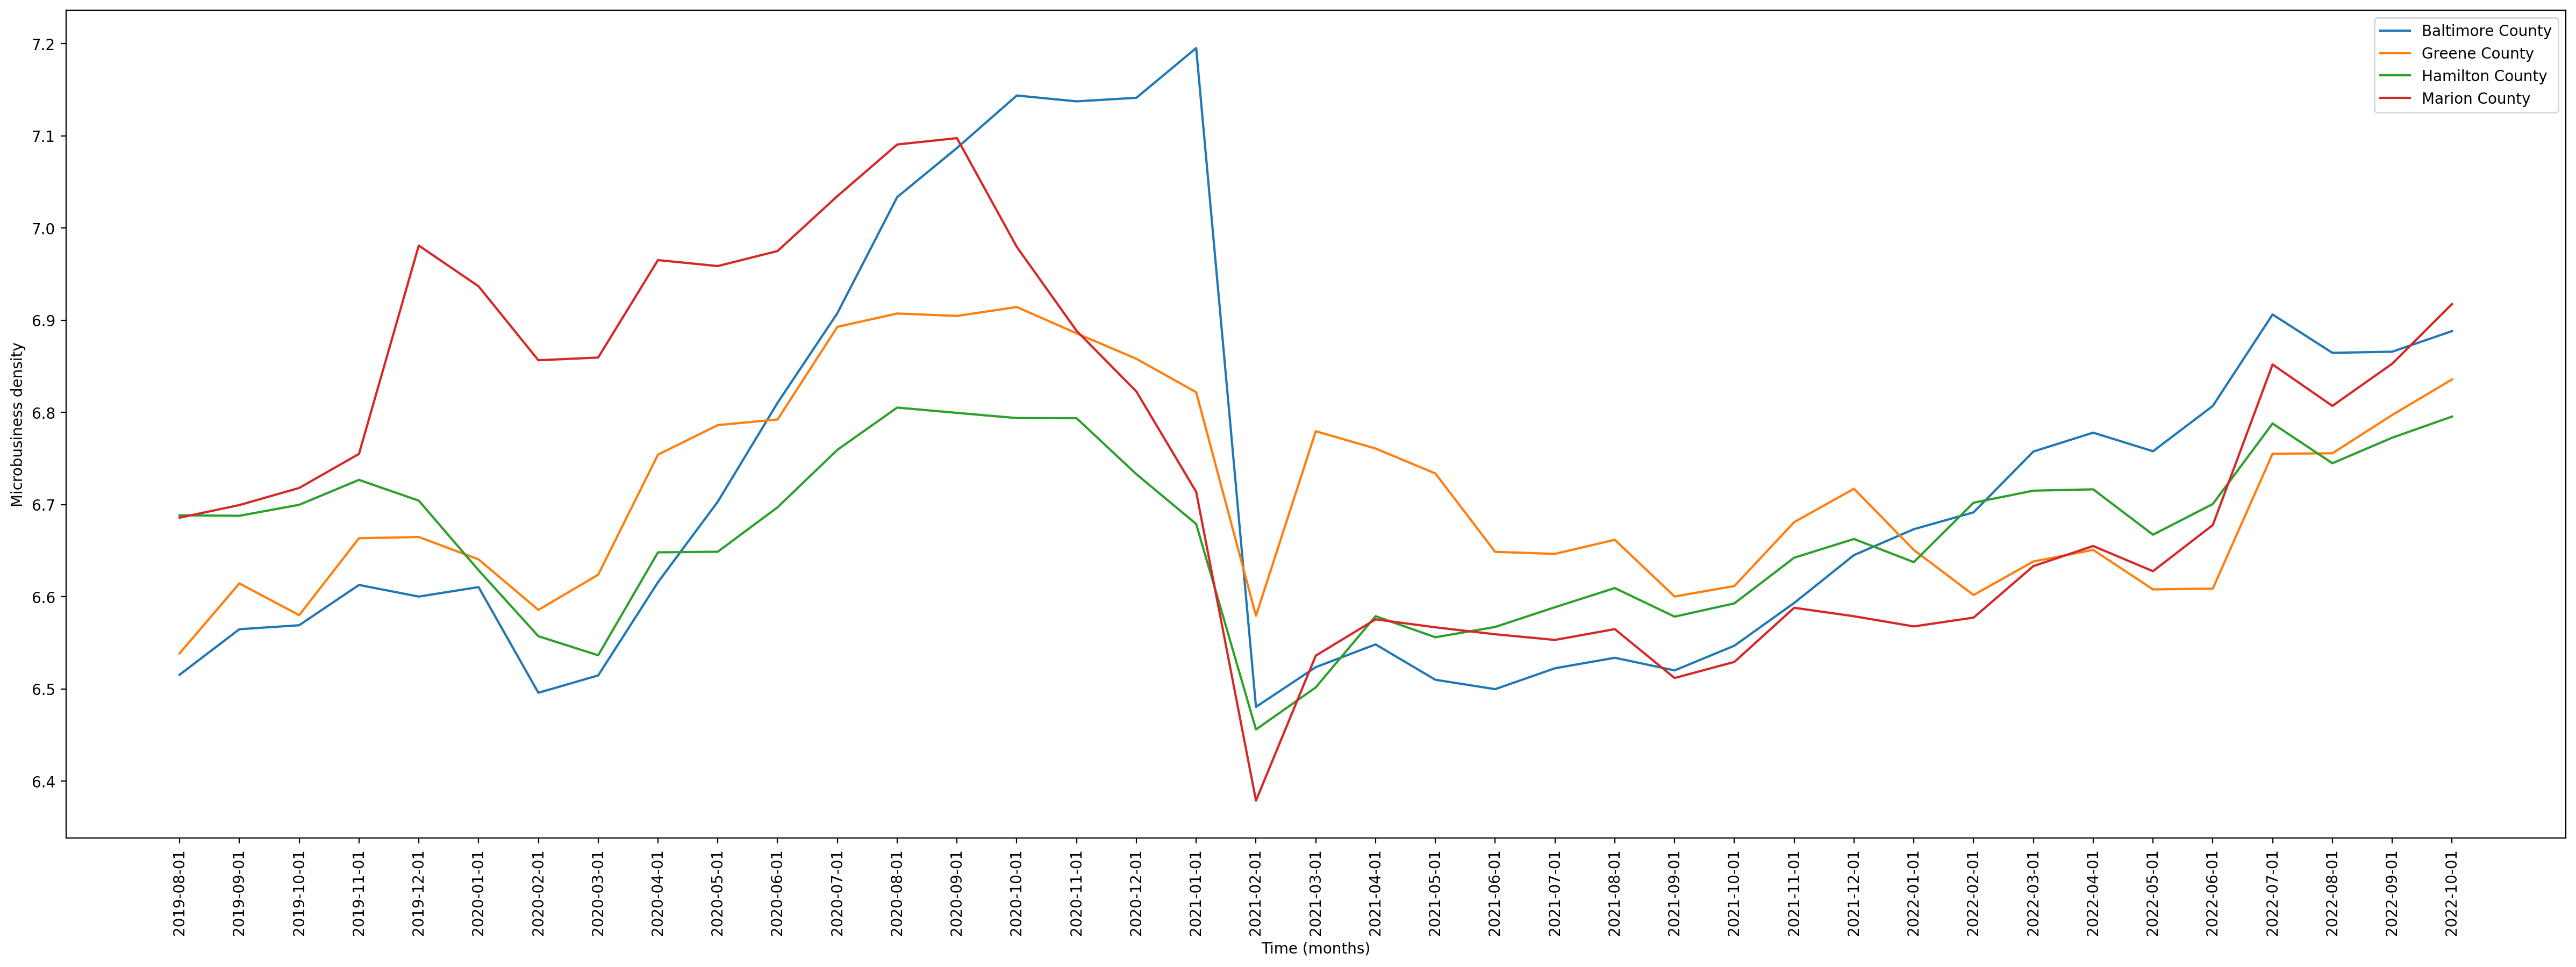

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10), dpi=200)
plt.plot(df.loc[24005, :], label='Baltimore County')  # Baltimore county
plt.plot(df.loc[29077, :], label='Greene County')    # Greene County
plt.plot(df.loc[39061, :], label='Hamilton County')  # Hamilton County
plt.plot(df.loc[18097, :], label='Marion County')    # Marion County

plt.xlabel("Time (months)")
plt.ylabel("Microbusiness density")

# Rotate x-axis labels
plt.xticks(rotation='vertical')

# Add legend
plt.legend()

plt.show()

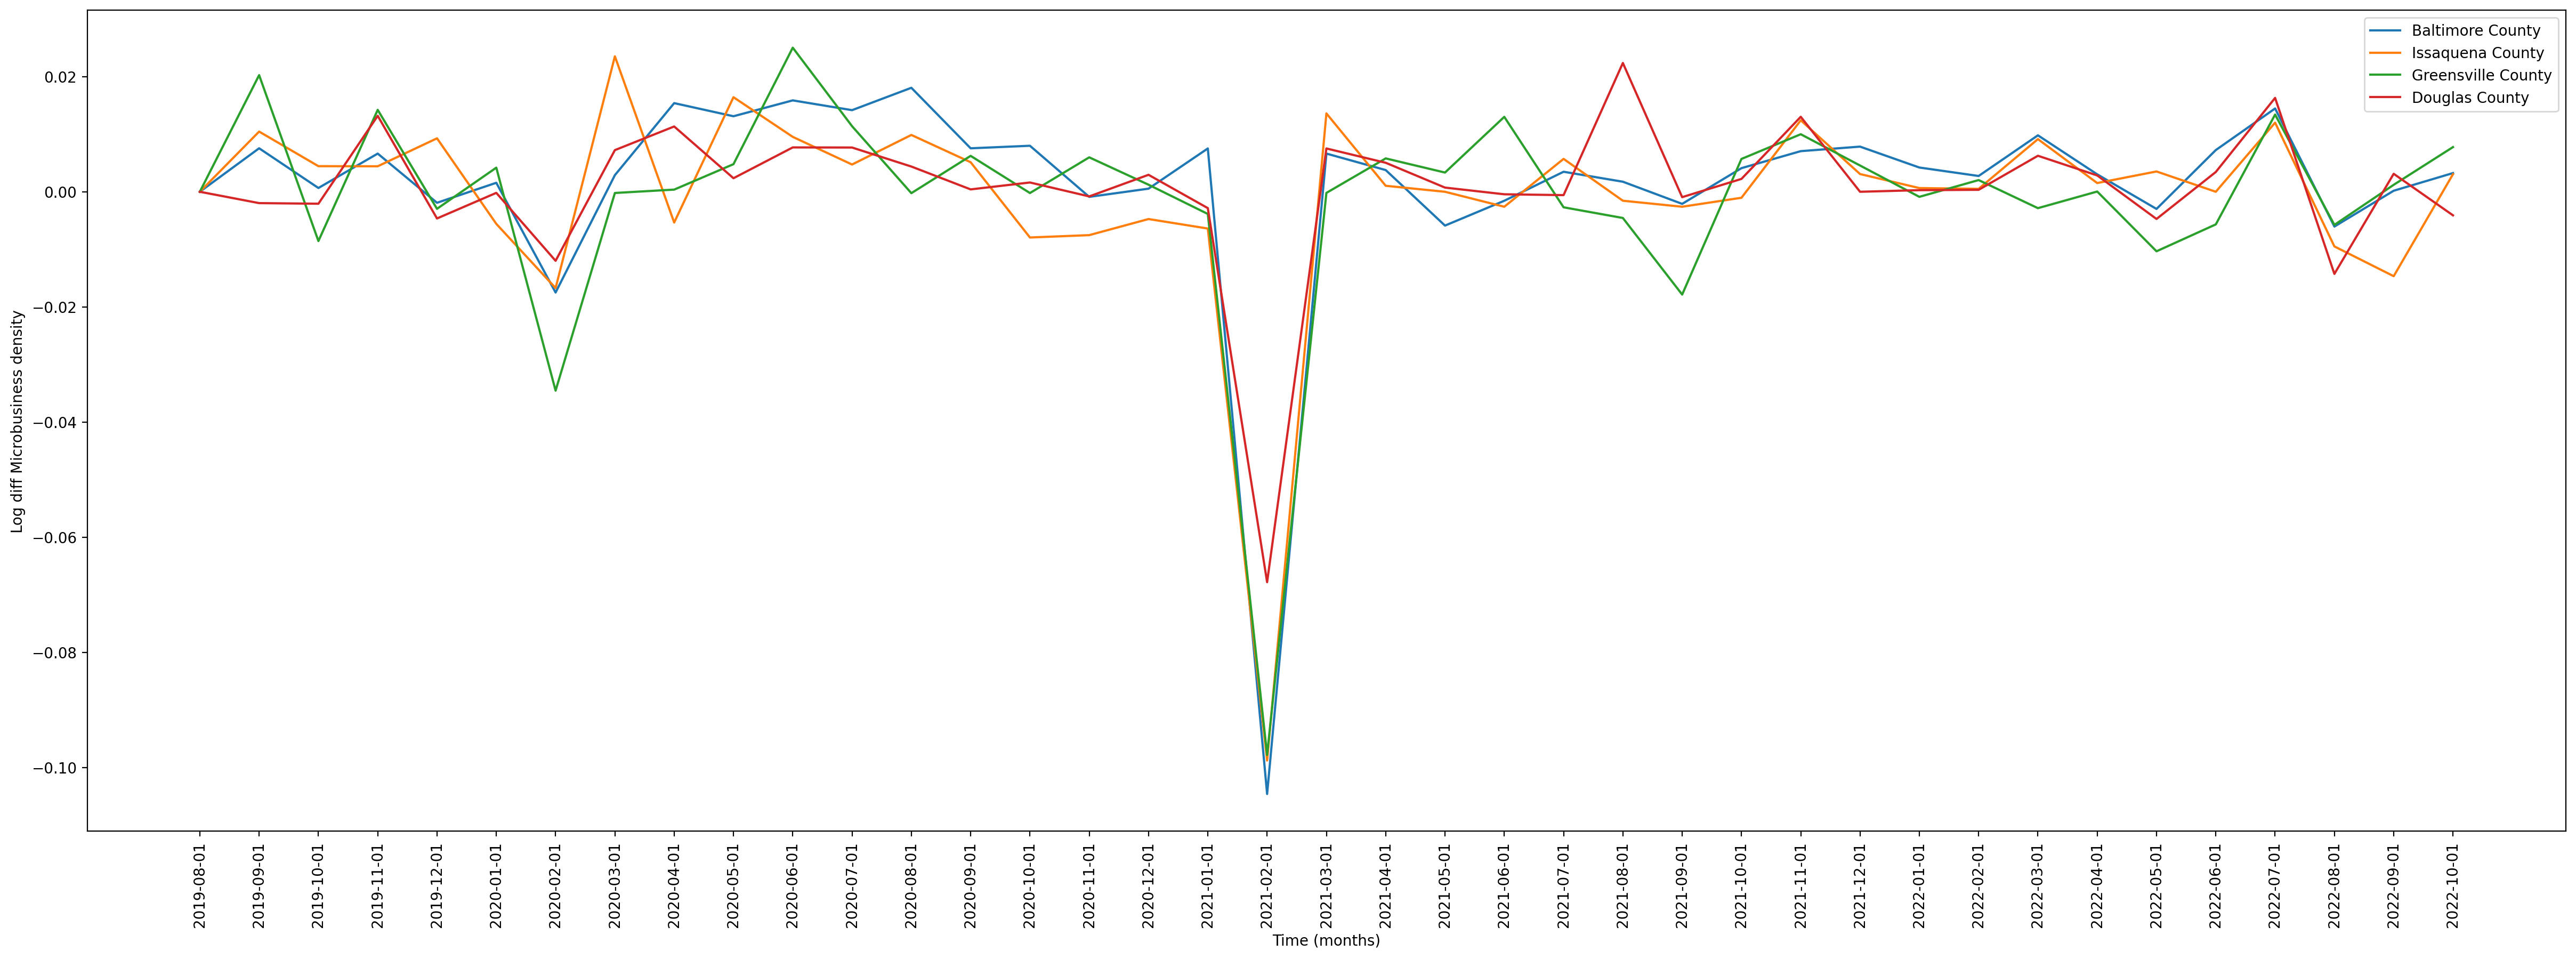

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10), dpi=200)
plt.plot(df_log_diff.loc[24005, :], label='Baltimore County')  # Baltimore county
plt.plot(df_log_diff.loc[19155, :], label='Issaquena County')    # Greene County
plt.plot(df_log_diff.loc[34017, :], label='Greensville County')  # Hamilton County
plt.plot(df_log_diff.loc[34025, :], label='Douglas County')    # Marion County

plt.xlabel("Time (months)")
plt.ylabel("Log diff Microbusiness density")

# Rotate x-axis labels
plt.xticks(rotation='vertical')

# Add legend
plt.legend()

plt.show()

In [39]:
df_ts = df_train[["cfips", "first_day_of_month", "microbusiness_density"]]
df_ts = df_ts.pivot(index='cfips', columns='first_day_of_month', values='microbusiness_density')
df_ts.columns.name = None
df_ts

,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,...,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01
cfips,,,,,,,,,,,,,,,,,,,,,
1001,3.007682,2.884870,3.055843,2.993233,2.993233,2.969090,2.909326,2.933231,3.000167,3.004948,...,3.296781,3.334431,3.336785,3.372082,3.313253,3.346197,3.437971,3.423852,3.442677,3.463856
1003,7.239156,7.290936,7.425439,7.426071,7.470274,7.413655,7.282522,7.309610,7.568799,7.603275,...,7.733397,7.823300,7.945311,7.979170,7.907365,8.507496,8.573463,8.491150,8.341701,8.359798
1005,1.073138,0.995794,1.160149,1.000628,1.000628,1.027229,1.022314,1.032144,1.086209,1.081294,...,1.186629,1.206827,1.196728,1.191678,1.186629,1.191678,1.216926,1.196728,1.206827,1.232074
1007,1.310777,1.305176,1.254761,1.254761,1.265965,1.253638,1.248041,1.264831,1.270428,1.287217,...,1.214165,1.236650,1.264755,1.253513,1.247892,1.275998,1.326588,1.292861,1.315346,1.287240
1009,1.544148,1.575892,1.546415,1.573625,1.555485,1.573217,1.536999,1.541526,1.577744,1.575481,...,1.752923,1.777708,1.797986,1.764189,1.748417,1.773202,1.831783,1.836289,1.852060,1.831783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,2.640386,2.858371,2.913635,3.008812,3.088637,3.150922,3.169494,3.237588,3.293302,3.311873,...,2.926768,2.892446,2.848763,2.851883,2.820681,2.783238,2.836282,2.811320,2.811320,2.823801
56039,26.433363,26.611856,26.736261,26.920164,26.903938,26.684565,26.738255,26.668457,27.119463,27.414764,...,25.532248,25.438322,25.636610,25.626175,25.506157,25.652266,25.939260,26.085369,26.090586,26.273220
56041,4.612016,4.338306,4.420419,4.372520,4.310935,4.367864,4.237172,4.182143,4.195900,4.443527,...,3.754478,3.954258,4.023147,4.064481,3.885368,3.906035,3.981813,3.974924,3.995591,4.009369


Text(0, 0.5, 'Microbusiness density')

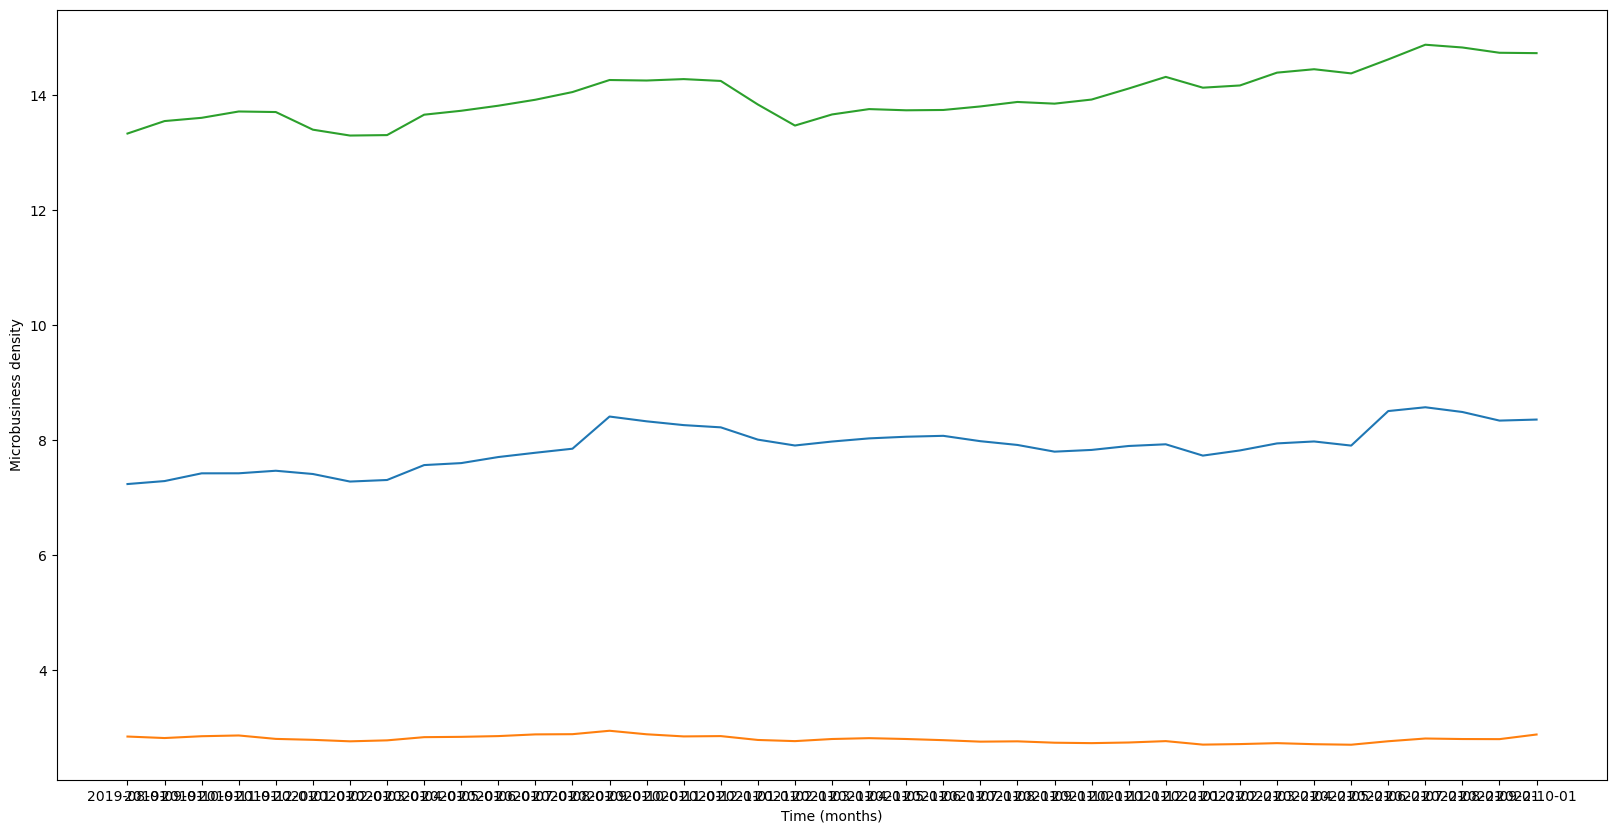

In [40]:
plt.figure(figsize=(20, 10))
plt.plot(df_ts.loc[1003, :])
plt.plot(df_ts.loc[40037, :])
plt.plot(df_ts.loc[12095, :])
# plt.plot(df_ts.loc[47065, :])
plt.xlabel("Time (months)")
plt.ylabel("Microbusiness density")

Text(0, 0.5, 'Microbusiness density')

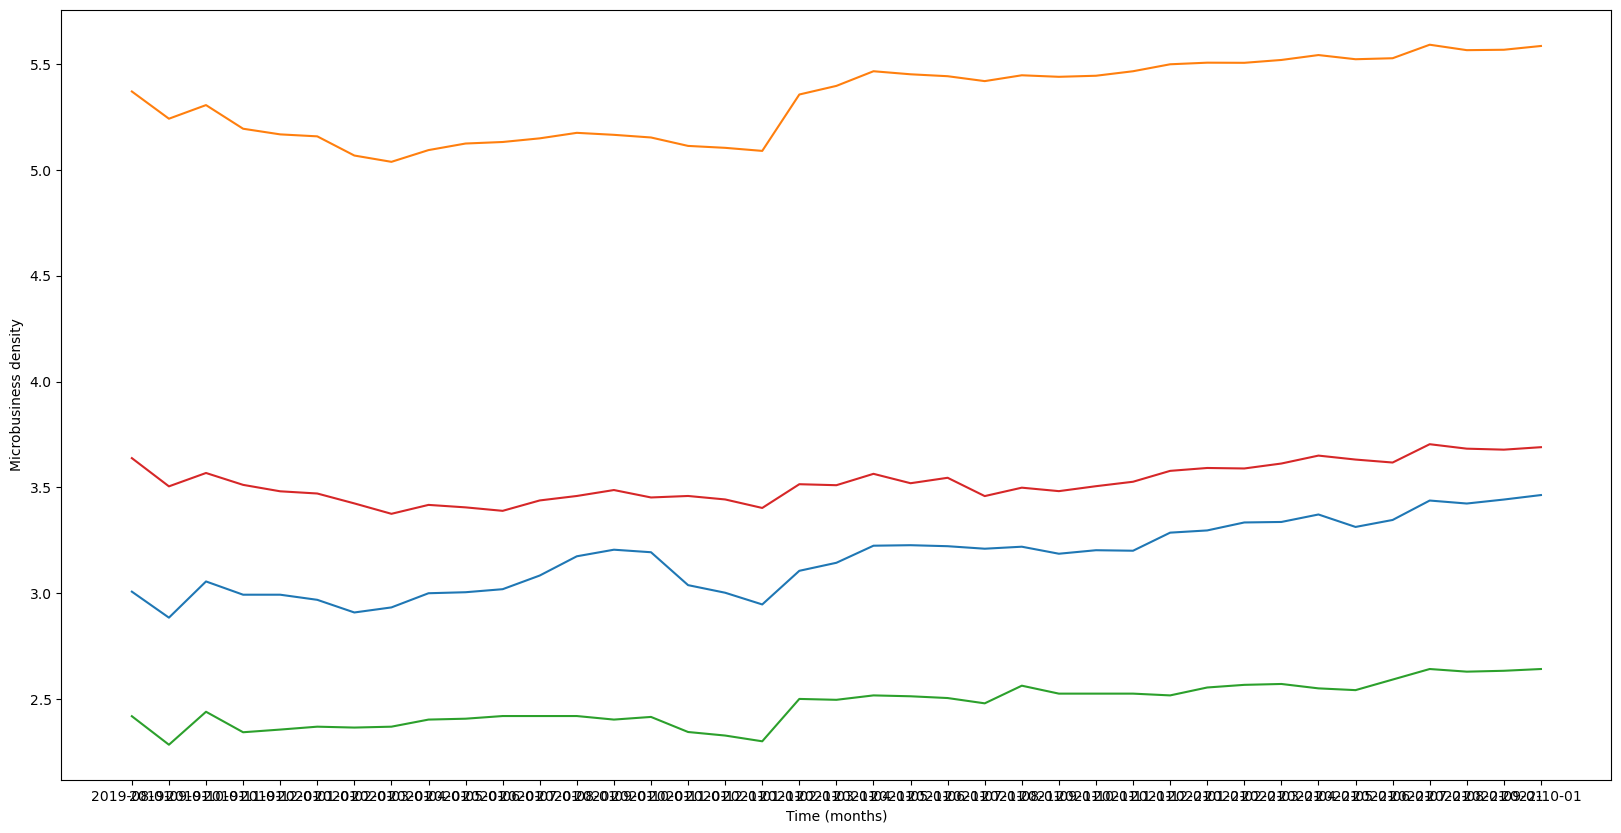

In [41]:
plt.figure(figsize=(20, 10))
plt.plot(df_ts.loc[1001, :])
plt.plot(df_ts.loc[6053, :])
plt.plot(df_ts.loc[21021, :])
plt.plot(df_ts.loc[42127, :])
plt.xlabel("Time (months)")
plt.ylabel("Microbusiness density")

In [ ]:
# cfips based KNN:
    # average monthly change of a & md by state
    # lags data
    # log_diff data


In [162]:
census

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,82.2,82.4,84.0,86.7,88.4,56037,15.3,15.2,14.8,13.7,...,0.6,0.6,1.0,0.9,1.0,71083,73008.0,74843,73384.0,76668.0
3138,83.5,85.9,87.1,89.1,90.5,56039,37.7,37.8,38.9,37.2,...,0.7,1.2,1.4,1.5,2.0,80049,83831.0,84678,87053.0,94498.0
3139,83.8,88.2,89.5,91.4,90.6,56041,11.9,10.5,11.1,12.6,...,1.2,1.2,1.4,1.7,0.9,54672,58235.0,63403,72458.0,75106.0
3140,76.4,78.3,78.2,82.8,85.4,56043,15.4,15.0,15.4,15.0,...,1.3,1.0,0.9,0.9,1.1,51362,53426.0,54158,57306.0,62271.0


In [170]:
df_ts[df_ts.index == 1001]

,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,...,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01
cfips,,,,,,,,,,,,,,,,,,,,,
1001,3.007682,2.88487,3.055843,2.993233,2.993233,2.96909,2.909326,2.933231,3.000167,3.004948,...,3.296781,3.334431,3.336785,3.372082,3.313253,3.346197,3.437971,3.423852,3.442677,3.463856
